# Suppressing instability on a Vlasov-Poisson system with an external electric field
## Example: Two stream distribution

$$\mu(v) = \frac{1}{2\sqrt{2\pi}} \left(
    \exp\left(-\frac{(v - \bar{v})^2}{2}\right)
    + \exp\left(-\frac{(v + \bar{v})^2}{2}\right)
\right). 
$$

$$f(0, x, v) = (1 +\varepsilon\, \cos(\beta x)) \,\mu(v).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

import optax

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver
from Utils.utils import plot_feq_distribution, plot_distribution

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

jax.config.update("jax_enable_x64", True)

print(jax.devices())

[CudaDevice(id=0)]


## Problem setup and forward solver setup

In [2]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
L = 10 * jnp.pi
LV = 6.0

In [3]:
mesh = make_mesh(L, LV, nx, nv)


mu1 = 2.4
f_eq = (jnp.exp(-0.5*(mesh.V - mu1)**2) + jnp.exp(-0.5*(mesh.V + mu1)**2))/(2*jnp.sqrt(2*jnp.pi))
epsilon1 = 0.001 # Value to change
epsilon2 = 0.0 # Value to change
k_0 = 0.2
f_iv = (1 + epsilon1 * jnp.cos(k_0 * mesh.X) + epsilon2 * jnp.sin(k_0 * mesh.X)) * f_eq

In [4]:
# Function to compute the external field H (not time-dependent)
def compute_external_field(ak, mesh):
    k = jnp.arange(1, len(ak[0,:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[0,:] @ jnp.cos(k[:, None] * k_0 * mesh.xs) \
            + ak[1,:] @ jnp.sin(k[:, None] * k_0 * mesh.xs)  # Vectorized computation
    return H

def compute_external_field_sin(ak, mesh):
    k = jnp.arange(1, len(ak[:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[:] @ jnp.sin(k[:, None] * k_0 * mesh.xs)  # Vectorized computation
    return H

#def compute_external_field(ak, mesh):
#    k = jnp.arange(1, len(ak[0,:]) + 1)  # Create an array of k values from 1 to len(a_k)
#    H = ak[0,:] @ jnp.cos(k[:, None] * k_0 * mesh.xs) \
#            + ak[1,:] @ jnp.sin(k[:, None] * k_0 * mesh.xs)  # Vectorized computation
#    return H

In [5]:
solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [6]:
# External field parameters (coefficients for the cosine terms)
k_total = 2
#ak1 = jax.random.uniform(jax.random.key(888), (2,k_total), minval=-1.0, maxval=1.0)
ak1 = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)
#ak2 = jax.random.uniform(jax.random.key(0), (2,k_total), minval=-1.0, maxval=1.0)
#a_k = jnp.array([
#    3.5164488e-04, 9.0411077e-06, -3.1953386e-05, -6.0834586e-06,
#    5.8570990e-06, 6.0852408e-06, -2.7067827e-06, -8.1664248e-06,
#    -8.8577590e-06, -9.7180082e-06, -9.5229143e-06, -9.5641644e-06,
#    -8.8652696e-06, -8.6681093e-06, -7.7312543e-06])
#b_k = jnp.array([-9.6406386e-04,
#    -5.9252861e-04, 2.9924628e-05, 4.2226049e-05, 5.3339943e-05,
#    3.5979556e-05, 2.5546415e-05, 1.0124806e-05, 6.6790512e-06,
#    1.3618927e-06, 3.0158180e-06, 7.7909431e-07, 3.0062322e-06,
#    1.2950333e-06, 3.2279252e-06])

#ak = jnp.stack([a_k, b_k])

# Compute the external field
H1 = compute_external_field_sin(ak1, mesh)
#H2 = compute_external_field(ak2, mesh)

# num_steps = int(t_final / dt)

In [7]:
f_array1, E_array1, ee_array1 = solver_jit(f_iv, 0.0*H1, t_final=t_final)
#f_array2, E_array2, ee_array2 = solver_jit(f_iv, 0.0*H2, t_final=t_final)

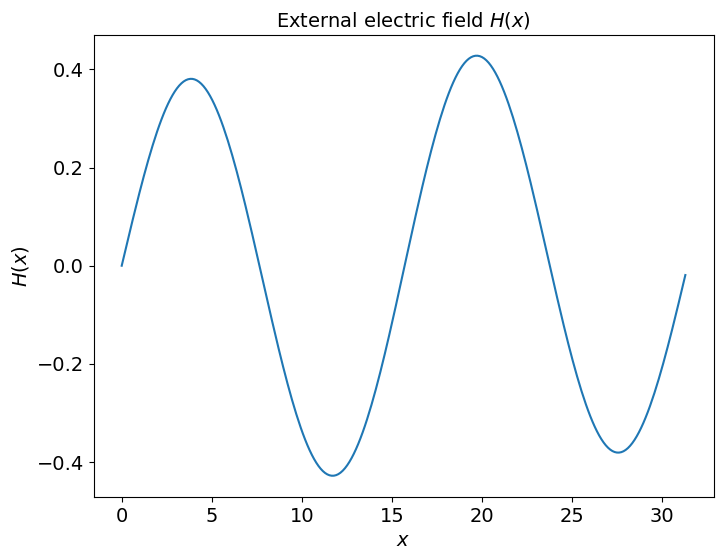

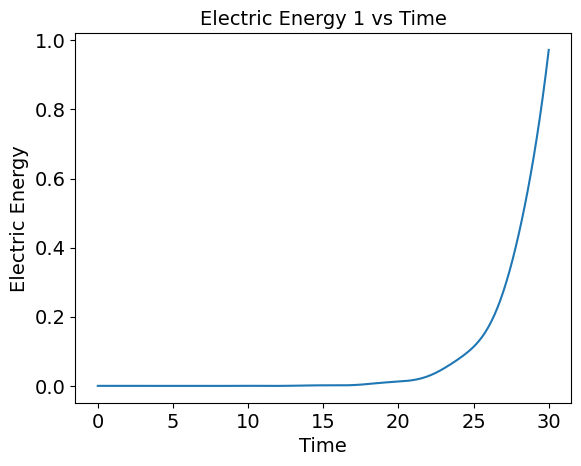

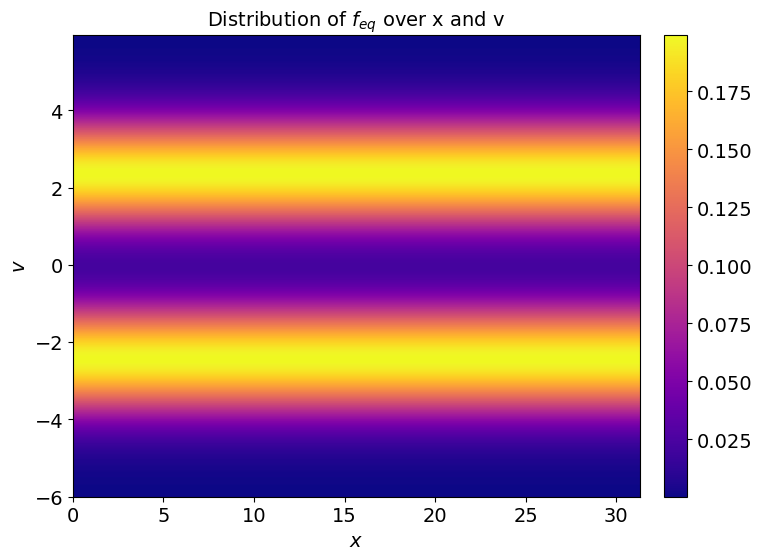

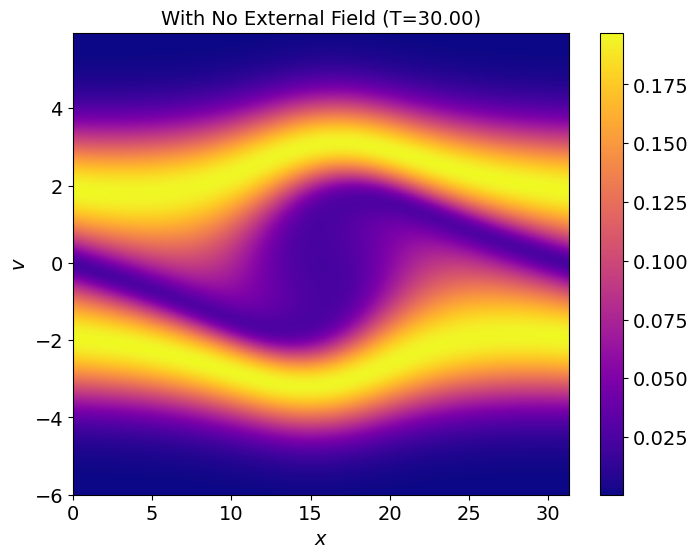

In [8]:
# Create a figure with a single plot for electric energy
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final / dt))


#fig, axs = plt.subplots(2, 2)

plt.plot(mesh.xs, H1)#, label='Init 1')
#plt.plot(mesh.xs, H2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
#plt.legend()
plt.show()

plt.plot(t_values, ee_array1)#, label='Init 1')
#plt.plot(t_values, ee_array2, label='Init 2')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy 1 vs Time')
#plt.legend()
#plt.grid(True)
plt.show()
         
# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(fig, ax, f_eq, 'Distribution of $f_{eq}$ over x and v', mesh)

plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

# f_array is already a 2D array, so pass it directly to the plot
plot_distribution(fig, ax, f_array1, 'With No External Field', t_final, mesh)

#plot_distribution(fig, axs[1], f_array2, 'With External Field 2', t_final)
plt.show()

## Optimization: finding the coefficients of the external electric field to suppress instability

## KL objective function

In [9]:
# Optimization through auto-differentiation with fixed basis.

def kl_divergence(f_final, solver, eps=1e-8):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = solver.f_eq / (jnp.sum(solver.f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(jax.scipy.special.rel_entr(f_final, f_eq + eps) * solver.mesh.dx * solver.mesh.dv)
    #kl_div = jnp.sum(f_final * jnp.log(f_final / (f_eq + eps) + eps)) * solver.mesh.dx * solver.mesh.dv
    return kl_div

@jax.jit
def cost_function_kl_1(a_k):
    H = compute_external_field_sin(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = kl_divergence(f_array, solver)
    return cost


grad_kl_1 = jax.jit(jax.grad(cost_function_kl_1))

@jax.jit
def cost_function_kl_2(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = kl_divergence(f_array, solver)
    return cost

grad_kl_2 = jax.jit(jax.grad(cost_function_kl_2))

### Far away initialization

In [10]:
# External field parameters (coefficients for the cosine and sine terms)
# Initial guess for the coefficients
# properly parametrized
k_total_1 = 2
ak_init_1 = jax.random.uniform(jax.random.key(888), (k_total_1,), minval=-1.0, maxval=1.0)
# over-parametrized
k_total_2 = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total_2), minval=-1.0, maxval=1.0)

#### Gradient descent linesearch

In [11]:
maxiter = 1700
solver_opt_lbl = optax.lbfgs()

def scan_fn_lbl_1(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_1(params, state=opt_state)
    updates, opt_state = solver_opt_lbl.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_1)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_1(params)
    return (params, opt_state), (obj_value, params)


#solver_opt_gdl = optax.chain(
#   optax.sgd(learning_rate=1.),
#    optax.scale_by_zoom_linesearch(max_linesearch_steps=50)
#)

#def scan_fn_gdl_1(carry, _):
#    params, opt_state = carry
#    value, grad = value_and_grad_1(params, state=opt_state)
#    updates, opt_state = solver_opt_gdl.update(grad, opt_state, params,
#                                           value=value, grad=grad, value_fn=cost_function_kl_1)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_1(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_1 = solver_opt_lbl.init(ak_init_1)
value_and_grad_1 = jax.jit(optax.value_and_grad_from_state(cost_function_kl_1))

# Run the optimization and collect objective values using `scan`
res_opt_kl_1, sols_1 = jax.lax.scan(scan_fn_lbl_1, (ak_init_1, opt_state_1), None, length=maxiter)

ak_opt_kl_1, state = res_opt_kl_1
objective_values_kl_1, aks_history_1 = sols_1

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_1 = compute_external_field_sin(ak_init_1, mesh)
H_kl_1 = compute_external_field_sin(ak_opt_kl_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)

f_final1 = ff_array1

error_kl_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_1))

jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_coeffs_far.npy'.format(epsilon1,epsilon2, k_total_1), aks_history_1)
jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_objective_far.npy'.format(epsilon1,epsilon2, k_total_1), objective_values_kl_1)

In [ ]:
solver_opt_lbl = optax.lbfgs()

def scan_fn_lbl_2(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_2(params, state=opt_state)
    updates, opt_state = solver_opt_lbl.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_2(params)
    return (params, opt_state), (obj_value, params)


#solver_opt_gdl = optax.chain(
#   optax.sgd(learning_rate=1.),
#    optax.scale_by_zoom_linesearch(max_linesearch_steps=50)
#)

# Define a scan function to iterate with `jax.lax.scan`
#def scan_fn_gdl_2(carry, _):
#    params, opt_state = carry
#    value, grad = value_and_grad_2(params, state=opt_state)
#    updates, opt_state = solver_opt_gdl.update(grad, opt_state, params,
#                                           value=value, grad=grad, value_fn=cost_function_kl_2)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_2(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_2 = solver_opt_lbl.init(ak_init_2)
value_and_grad_2 = jax.jit(optax.value_and_grad_from_state(cost_function_kl_2))

# Run the optimization and collect objective values using `scan`
res_opt_kl_2, sols_2 = jax.lax.scan(scan_fn_lbl_2, (ak_init_2, opt_state_2), None, length=maxiter)

ak_opt_kl_2, state = res_opt_kl_2
objective_values_kl_2, aks_history_2 = sols_2

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_kl_2 = compute_external_field(ak_opt_kl_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final2 = ff_array2

error_kl_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_2))

jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_coeffs_far.npy'.format(epsilon1,epsilon2, k_total_2), aks_history_2)
jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_objective_far.npy'.format(epsilon1,epsilon2, k_total_2), objective_values_kl_2)

#### Gradient descent constant step

In [ ]:
maxiter = 4000

solver_opt_lb = optax.lbfgs(learning_rate=1e-8, linesearch=None)

def scan_fn_lb_1(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_1(params)#, state=opt_state)
    updates, opt_state = solver_opt_lb.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_1)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_1(params)
    return (params, opt_state), (obj_value, params)


### Gradient descent w/ constant step
#learning_rate = 1e-8
#solver_opt_gd = optax.sgd(learning_rate=learning_rate)

# Define a scan function to iterate with `jax.lax.scan`
#def scan_fn_gd_1(carry, _):
#    params, opt_state = carry
#    grad_ = grad_1(params)
#    updates, opt_state = solver_opt_gd.update(grad_, opt_state, params)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_1(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_1 = solver_opt_lb.init(ak_init_1)
value_and_grad_1 = jax.jit(jax.value_and_grad(cost_function_kl_1))
#grad_1 = jax.jit(jax.grad(cost_function_kl_1))

# Run the optimization and collect objective values using `scan`
res_opt_kl_1, sols_1 = jax.lax.scan(scan_fn_lb_1, (ak_init_1, opt_state_1), None, length=maxiter)

ak_opt_kl_1, state = res_opt_kl_1
objective_values_kl_1, aks_history_1 = sols_1

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_1 = compute_external_field_sin(ak_init_1, mesh)
H_kl_1 = compute_external_field_sin(ak_opt_kl_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)

f_final1 = ff_array1

error_kl_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_1))

jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_coeffs_far.npy'.format(epsilon1,epsilon2, k_total_1), aks_history_1)
jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_objective_far.npy'.format(epsilon1,epsilon2, k_total_1), objective_values_kl_1)

In [ ]:
solver_opt_lb = optax.lbfgs(learning_rate=1e-8, linesearch=None)

def scan_fn_lb_2(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_2(params)#, state=opt_state)
    updates, opt_state = solver_opt_lb.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_2(params)
    return (params, opt_state), (obj_value, params)


### Gradient descent w/ constant step
#learning_rate = 1e-8
#solver_opt_gd = optax.sgd(learning_rate=learning_rate)
# Define a scan function to iterate with `jax.lax.scan`
#def scan_fn_gd_2(carry, _):
#    params, opt_state = carry
#    grad_ = grad_2(params)
#    updates, opt_state = solver_opt_gd.update(grad, opt_state, params,)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_2(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_2 = solver_opt_lb.init(ak_init_2)
value_and_grad_2 = jax.jit(jax.value_and_grad(cost_function_kl_2))
#grad_2 = jax.jit(jax.grad(cost_function_kl_2))

# Run the optimization and collect objective values using `scan`
res_opt_kl_2, sols_2 = jax.lax.scan(scan_fn_lb_2, (ak_init_2, opt_state_2), None, length=maxiter)

ak_opt_kl_2, state = res_opt_kl_2
objective_values_kl_2, aks_history_2 = sols_2

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_kl_2 = compute_external_field(ak_opt_kl_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final2 = ff_array2

error_kl_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_2))

jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_coeffs_far.npy'.format(epsilon1,epsilon2, k_total_2), aks_history_2)
jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_objective_far.npy'.format(epsilon1,epsilon2, k_total_2), objective_values_kl_2)

### Near initialization

In [ ]:
# External field parameters (coefficients for the cosine and sine terms)
# Initial guess for the coefficients
# properly parametrized
k_total_1 = 2
ak_init_1 = jax.random.uniform(jax.random.key(888), (k_total_1,), minval=-0.1, maxval=0.1)
# over-parametrized
k_total_2 = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total_2), minval=-0.1, maxval=0.1)

#### Gradient descent linesearch

In [ ]:
maxiter = 1700

solver_opt_lbl = optax.lbfgs()

def scan_fn_lbl_1(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_1(params, state=opt_state)
    updates, opt_state = solver_opt_lbl.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_1)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_1(params)
    return (params, opt_state), (obj_value, params)


#solver_opt_gdl = optax.chain(
#   optax.sgd(learning_rate=1.),
#    optax.scale_by_zoom_linesearch(max_linesearch_steps=50)
#)

#def scan_fn_gdl_1(carry, _):
#    params, opt_state = carry
#    value, grad = value_and_grad_1(params, state=opt_state)
#    updates, opt_state = solver_opt_gdl.update(grad, opt_state, params,
#                                           value=value, grad=grad, value_fn=cost_function_kl_1)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_1(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_1 = solver_opt_lbl.init(ak_init_1)
value_and_grad_1 = jax.jit(optax.value_and_grad_from_state(cost_function_kl_1))

# Run the optimization and collect objective values using `scan`
res_opt_kl_1, sols_1 = jax.lax.scan(scan_fn_lbl_1, (ak_init_1, opt_state_1), None, length=maxiter)

ak_opt_kl_1, state = res_opt_kl_1
objective_values_kl_1, aks_history_1 = sols_1

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_1 = compute_external_field_sin(ak_init_1, mesh)
H_kl_1 = compute_external_field_sin(ak_opt_kl_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)

f_final1 = ff_array1

error_kl_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_1))

jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_coeffs_near.npy'.format(epsilon1,epsilon2, k_total_1), aks_history_1)
jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_objective_near.npy'.format(epsilon1,epsilon2, k_total_1), objective_values_kl_1)

In [ ]:
solver_opt_lbl = optax.lbfgs()

def scan_fn_lbl_2(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_2(params, state=opt_state)
    updates, opt_state = solver_opt_lbl.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_2(params)
    return (params, opt_state), (obj_value, params)


#solver_opt_gdl = optax.chain(
#   optax.sgd(learning_rate=1.),
#    optax.scale_by_zoom_linesearch(max_linesearch_steps=50)
#)

# Define a scan function to iterate with `jax.lax.scan`
#def scan_fn_gdl_2(carry, _):
#    params, opt_state = carry
#    value, grad = value_and_grad_2(params, state=opt_state)
#    updates, opt_state = solver_opt_gdl.update(grad, opt_state, params,
#                                           value=value, grad=grad, value_fn=cost_function_kl_2)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_2(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_2 = solver_opt_lbl.init(ak_init_2)
value_and_grad_2 = jax.jit(optax.value_and_grad_from_state(cost_function_kl_2))

# Run the optimization and collect objective values using `scan`
res_opt_kl_2, sols_2 = jax.lax.scan(scan_fn_lbl_2, (ak_init_2, opt_state_2), None, length=maxiter)

ak_opt_kl_2, state = res_opt_kl_2
objective_values_kl_2, aks_history_2 = sols_2

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_kl_2 = compute_external_field(ak_opt_kl_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final2 = ff_array2

error_kl_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_2))

jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_coeffs_near.npy'.format(epsilon1,epsilon2, k_total_2), aks_history_2)
jnp.save('Results_coeff/Two_Stream/new/LBL_KL_eps1={}_eps2={}_k={}_objective_near.npy'.format(epsilon1,epsilon2, k_total_2), objective_values_kl_2)

#### Gradient descent constant step

In [ ]:
maxiter = 4000

solver_opt_lb = optax.lbfgs(learning_rate=1e-8, linesearch=None)

def scan_fn_lb_1(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_1(params)#, state=opt_state)
    updates, opt_state = solver_opt_lb.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_1)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_1(params)
    return (params, opt_state), (obj_value, params)


### Gradient descent w/ constant step
#learning_rate = 1e-8
#solver_opt_gd = optax.sgd(learning_rate=learning_rate)

# Define a scan function to iterate with `jax.lax.scan`
#def scan_fn_gd_1(carry, _):
#    params, opt_state = carry
#    grad_ = grad_1(params)
#    updates, opt_state = solver_opt_gd.update(grad_, opt_state, params)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_1(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_1 = solver_opt_lb.init(ak_init_1)
value_and_grad_1 = jax.jit(jax.value_and_grad(cost_function_kl_1))
#grad_1 = jax.jit(jax.grad(cost_function_kl_1))

# Run the optimization and collect objective values using `scan`
res_opt_kl_1, sols_1 = jax.lax.scan(scan_fn_lb_1, (ak_init_1, opt_state_1), None, length=maxiter)

ak_opt_kl_1, state = res_opt_kl_1
objective_values_kl_1, aks_history_1 = sols_1

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_1 = compute_external_field_sin(ak_init_1, mesh)
H_kl_1 = compute_external_field_sin(ak_opt_kl_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)

f_final1 = ff_array1

error_kl_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_1))

jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_coeffs_near.npy'.format(epsilon1,epsilon2, k_total_1), aks_history_1)
jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_objective_near.npy'.format(epsilon1,epsilon2, k_total_1), objective_values_kl_1)

In [ ]:
solver_opt_lb = optax.lbfgs(learning_rate=1e-8, linesearch=None)

def scan_fn_lb_2(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad_2(params)#, state=opt_state)
    updates, opt_state = solver_opt_lb.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl_2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl_2(params)
    return (params, opt_state), (obj_value, params)


### Gradient descent w/ constant step
#learning_rate = 1e-8
#solver_opt_gd = optax.sgd(learning_rate=learning_rate)
# Define a scan function to iterate with `jax.lax.scan`
#def scan_fn_gd_2(carry, _):
#    params, opt_state = carry
#    grad_ = grad_2(params)
#    updates, opt_state = solver_opt_gd.update(grad, opt_state, params,)
#    params = optax.apply_updates(params, updates)
#    obj_value = cost_function_kl_2(params)
#    return (params, opt_state), (obj_value, params)

In [ ]:
# Initial state
opt_state_2 = solver_opt_lb.init(ak_init_2)
value_and_grad_2 = jax.jit(jax.value_and_grad(cost_function_kl_2))
#grad_2 = jax.jit(jax.grad(cost_function_kl_2))

# Run the optimization and collect objective values using `scan`
res_opt_kl_2, sols_2 = jax.lax.scan(scan_fn_lb_2, (ak_init_2, opt_state_2), None, length=maxiter)

ak_opt_kl_2, state = res_opt_kl_2
objective_values_kl_2, aks_history_2 = sols_2

#ak_opt_kl_1 = jnp.load('Results_coeff/Two_Stream/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_kl_2 = compute_external_field(ak_opt_kl_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final2 = ff_array2

error_kl_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_2))

jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_coeffs_near.npy'.format(epsilon1,epsilon2, k_total_2), aks_history_2)
jnp.save('Results_coeff/Two_Stream/new/LB_KL_eps1={}_eps2={}_k={}_objective_near.npy'.format(epsilon1,epsilon2, k_total_2), objective_values_kl_2)

In [37]:
print("hello")

hello
